In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

In [98]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver_nt.rds")
cadaver = readRDS("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/phyloseq_files/cadaver.rds")

In [34]:
sample_tab = read.csv("/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/final_biom/mapfile_metadata.csv")

In [35]:
colnames(sample_tab)[colnames(sample_tab)=="X.SampleID"] <- "SampleID"

# Alpha Diversity

## Shannon Diversity Calculations

### Grouping by BMI and sample type

In [36]:
sha = estimate_richness(cadaver_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = left_join(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Sample_Type") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Sample_Type")

stats.sha = dfsha %>%
    group_by(Sample_Type, BMI_Cat) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(BMI_Cat))
stats.sha

Joining, by = "SampleID"
Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

Sample_Type,BMI_Cat,median,mean,sd,sem
Brain,Normal,1.7674956,1.8373539,0.3911630,0.10099785
Heart,Normal,1.6449873,1.8199470,0.3086894,0.08561503
Liver,Normal,1.9329892,1.8939634,0.4109723,0.10274307
Prostate,Normal,3.7005166,3.4188910,0.6089476,0.23016057
Spleen,Normal,2.3017766,2.0689230,0.8180924,0.23616292
Uterus,Normal,2.5895611,2.6432666,0.5083855,0.17974143
Brain,Obese,2.0651599,2.1537126,0.4013500,0.15169603
Heart,Obese,0.7147290,0.8465489,0.7782730,0.38913649
Liver,Obese,1.6418726,1.8474392,0.9568525,0.39063341
Prostate,Obese,0.9274766,1.6944042,1.7309880,0.99938640


In [37]:
write.csv(stats.sha, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/organ_v_BMI.stats.shannon.csv")

In [38]:
#Order by sample type mean

avg_obs <- aggregate(Shannon ~ Sample_Type, data = dfsha, mean)
dfsha$Sample_Type <-factor(dfsha$Sample_Type, levels=avg_obs[order(avg_obs$Shannon), "Sample_Type"])

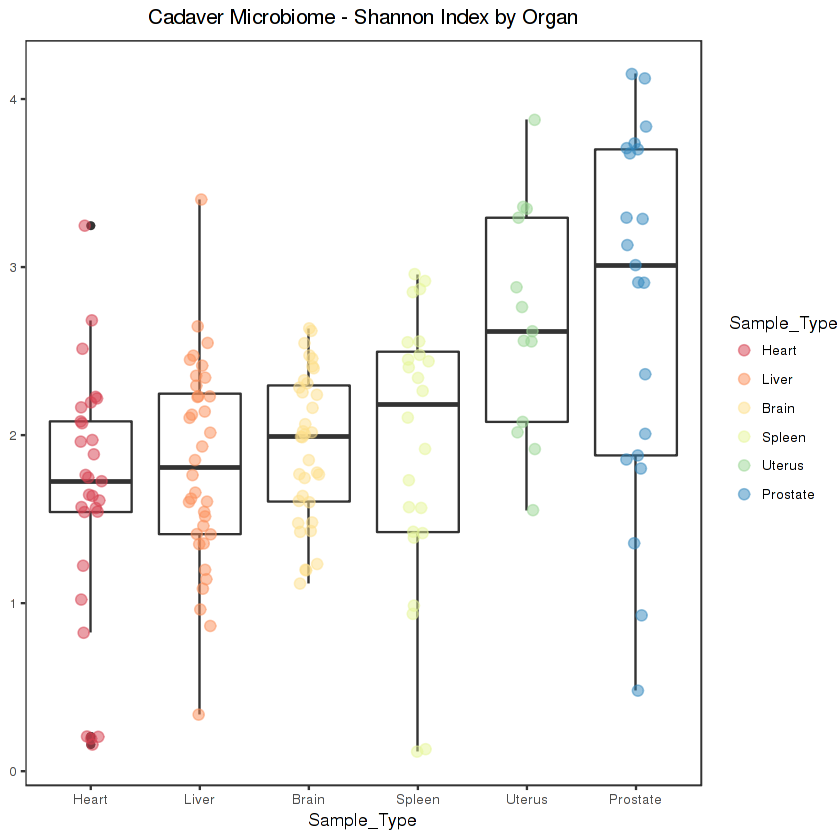

In [39]:
p = ggplot(na.omit(dfsha), aes(x = Sample_Type, y = Shannon)) + ggtitle("Cadaver Microbiome - Shannon Index by Organ") 

p = p + geom_boxplot() + ylab("Shannon")

p = p + geom_point(size = 2.5,alpha=.5, aes(color = Sample_Type),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

In [40]:
krusk = kruskal.test(Shannon ~ Sample_Type, data=dfsha) 
krusk


	Kruskal-Wallis rank sum test

data:  Shannon by Sample_Type
Kruskal-Wallis chi-squared = 28.791, df = 5, p-value = 2.549e-05


In [26]:
dunn = dunn.test(dfsha$Shannon, g=dfsha$Sample_Type, method="bonferroni")
write.csv(dunn, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/sample_type.dfsha.krusk.dunn.csv")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 28.7908, df = 5, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Brain      Heart      Liver   Prostate     Spleen
---------+-------------------------------------------------------
   Heart |   1.287812
         |     1.0000
         |
   Liver |   0.671309  -0.657348
         |     1.0000     1.0000
         |
Prostate |  -3.038233  -4.055396  -3.634532
         |    0.0178*    0.0004*    0.0021*
         |
  Spleen |  -0.389457  -1.545897  -0.996387   2.461173
         |     1.0000     0.9160     1.0000     0.1039
         |
  Uterus |  -2.922887  -3.813132  -3.426427  -0.313736  -2.457063
         |     0.0260    0.0010*    0.0046*     1.0000     0.1051

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 28.79076

$Z
 [1]  1.2878124  0.6713095 -0.6573484 -3.0382335 -4.0553963 -3.6345325
 [7] -0.3894575 -1.5458972 -0.9963877  2.4611735 -2.9228871 -3.8131322
[13] -3.4264276 -0.3137364 -2.4570633

$P
 [1] 9.890563e-02 2.510117e-01 2.554785e-01 1.189848e-03 2.502469e-05
 [6] 1.392426e-04 3.484689e-01 6.106470e-02 1.595309e-01 6.924169e-03
[11] 1.734011e-03 6.860835e-05 3.057884e-04 3.768606e-01 7.003901e-03

$P.adjusted
 [1] 1.0000000000 1.0000000000 1.0000000000 0.0178477140 0.0003753703
 [6] 0.0020886384 1.0000000000 0.9159705092 1.0000000000 0.1038625308
[11] 0.0260101651 0.0010291252 0.0045868259 1.0000000000 0.1050585107

$comparisons
 [1] "Brain - Heart"     "Brain - Liver"     "Heart - Liver"    
 [4] "Brain - Prostate"  "Heart - Prostate"  "Liver - Prostate" 
 [7] "Brain - Spleen"    "Heart - Spleen"    "Liver - Spleen"   
[10] "Prostate - Spleen" "Brain - Uterus"    "Heart - Uterus"   
[13] "Liver - Uterus"    "Prostate - Uterus" "Spleen - Uterus"

### Grouping by sex and sample type

In [106]:
sha = estimate_richness(cadaver_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = left_join(sha, sample_tab, on="SampleID")

stats.sha = dfsha %>%
    group_by(Sample_Type, Sex) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(Sex))
stats.sha

Joining, by = "SampleID"
Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

Sample_Type,Sex,median,mean,sd,sem
Brain,F,1.765579,1.833949,0.4425151,0.12273161
Heart,F,1.638158,1.743195,0.3992206,0.12036953
Liver,F,1.761997,1.800682,0.4316386,0.11971500
Spleen,F,1.495821,1.656175,0.8532749,0.26982922
Uterus,F,2.618174,2.678391,0.6736154,0.18682729
Brain,M,2.010282,1.984889,0.4428566,0.09441735
Heart,M,1.816592,1.568379,0.9150456,0.21567832
Liver,M,2.014469,1.836929,0.6980468,0.14555282
Prostate,M,3.011616,2.768379,1.0745747,0.23449142
Spleen,M,2.421423,2.129261,0.7627814,0.20386190


In [71]:
write.csv(stats.obs, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/organ_v_sex.stats.shannon.csv")

In [91]:
#Order by sample type mean

avg_obs <- aggregate(Shannon ~ Sample_Type, data = dfsha, mean)
dfsha$Sample_Type <-factor(dfsha$Sample_Type, levels=avg_obs[order(avg_obs$Shannon), "Sample_Type"])

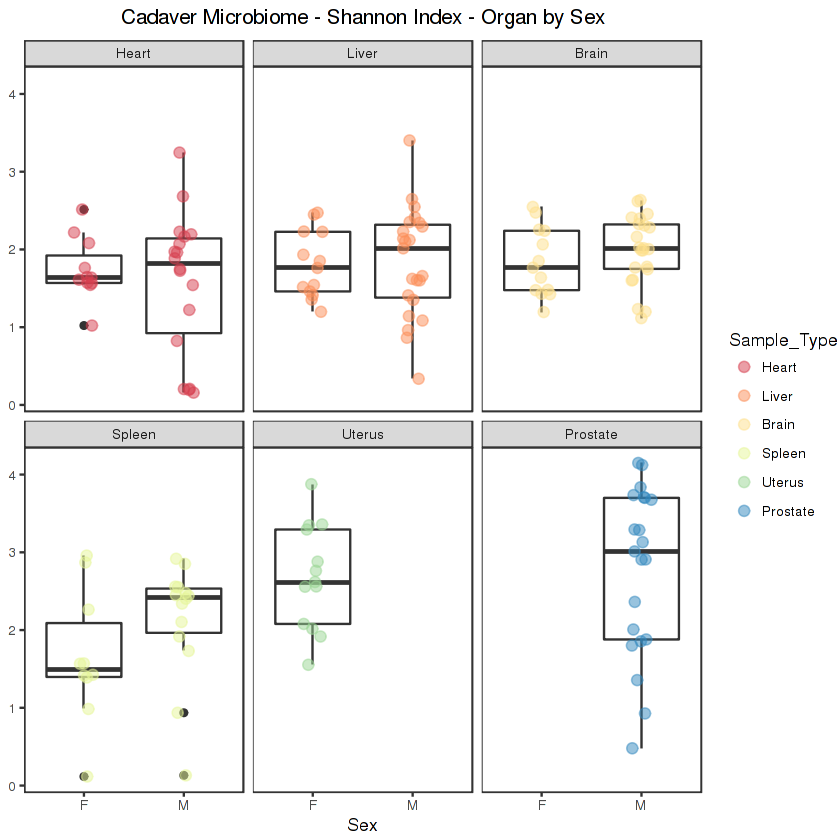

In [92]:
p = ggplot(na.omit(dfsha), aes(x = Sex, y = Shannon)) + ggtitle("Cadaver Microbiome - Shannon Index - Organ by Sex") 

p = p + geom_boxplot() + ylab("Shannon")

p = p + geom_point(size = 2.5,alpha=.5, aes(color = Sample_Type),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Sample_Type)

p

In [107]:
heart <- dfsha[which(dfsha$Sample_Type=='Heart'),]
brain <- dfsha[which(dfsha$Sample_Type=='Brain'),]
liver <- dfsha[which(dfsha$Sample_Type=='Liver'),]
spleen <- dfsha[which(dfsha$Sample_Type=='Spleen'),]
uterus <- dfsha[which(dfsha$Sample_Type=='Uterus'),]
prostate <- dfsha[which(dfsha$Sample_Type=='Prostate'),]
gonad <- rbind(uterus,prostate)

In [108]:
krusk_heart = kruskal.test(Shannon ~ Sex, data=heart) 
krusk_brain = kruskal.test(Shannon ~ Sex, data=brain) 
krusk_liver = kruskal.test(Shannon ~ Sex, data=liver) 
krusk_spleen = kruskal.test(Shannon ~ Sex, data=spleen) 
krusk_gonad = kruskal.test(Shannon ~ Sex, data=gonad)  

krusk_heart
krusk_brain
krusk_liver
krusk_spleen
krusk_gonad


	Kruskal-Wallis rank sum test

data:  Shannon by Sex
Kruskal-Wallis chi-squared = 0.0020202, df = 1, p-value = 0.9641



	Kruskal-Wallis rank sum test

data:  Shannon by Sex
Kruskal-Wallis chi-squared = 1.049, df = 1, p-value = 0.3057



	Kruskal-Wallis rank sum test

data:  Shannon by Sex
Kruskal-Wallis chi-squared = 0.045828, df = 1, p-value = 0.8305



	Kruskal-Wallis rank sum test

data:  Shannon by Sex
Kruskal-Wallis chi-squared = 2.3177, df = 1, p-value = 0.1279



	Kruskal-Wallis rank sum test

data:  Shannon by Sex
Kruskal-Wallis chi-squared = 0.22889, df = 1, p-value = 0.6324


## Observed Diversity Calculations

### Grouping by BMI and sample type

In [93]:
obs = estimate_richness(cadaver_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = left_join(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("Sample_Type") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("Sample_Type")

stats.obs = dfobs %>%
    group_by(BMI_Cat, Sample_Type) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(BMI_Cat))
stats.obs

Joining, by = "SampleID"
Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

BMI_Cat,Sample_Type,median,mean,sd,sem
Normal,Brain,36.0,35.26667,6.441680,1.663235
Normal,Heart,32.0,34.53846,9.777656,2.711834
Normal,Liver,39.0,41.25000,12.704330,3.176082
Normal,Prostate,144.0,120.57143,50.970113,19.264892
Normal,Spleen,49.0,50.50000,17.032055,4.916731
Normal,Uterus,79.5,89.87500,27.189481,9.612933
Obese,Brain,41.0,50.00000,23.388031,8.839845
Obese,Heart,20.0,21.00000,6.683313,3.341656
Obese,Liver,39.0,62.00000,45.650849,18.636881
Obese,Prostate,16.0,64.66667,91.308999,52.717275


In [28]:
write.csv(stats.obs, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/organ_v_BMI.stats.observed.csv")

In [94]:
#Order by sample type mean

avg_obs <- aggregate(Observed ~ Sample_Type, data = dfobs, mean)
dfobs$Sample_Type <-factor(dfobs$Sample_Type, levels=avg_obs[order(avg_obs$Observed), "Sample_Type"])

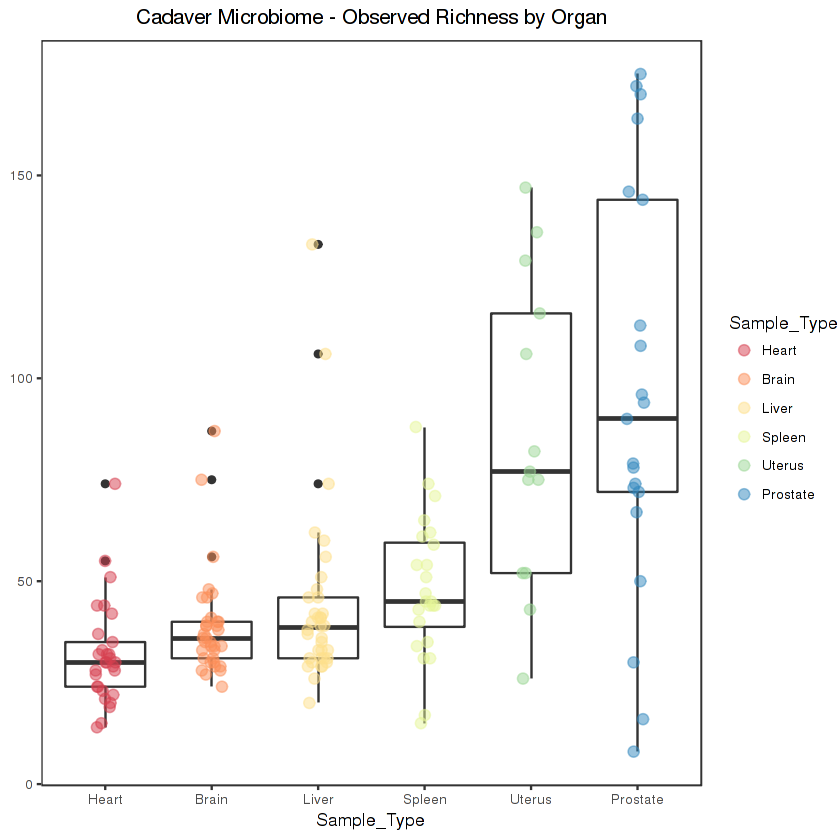

In [95]:
p = ggplot(na.omit(dfobs), aes(x = Sample_Type, y = Observed)) + ggtitle("Cadaver Microbiome - Observed Richness by Organ")

p = p + geom_boxplot() + ylab("# of Observed OTUs")

p = p + geom_point(size = 2.5,alpha=.5, aes(color = Sample_Type),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

#p = p + facet_wrap(~BMI_Cat)

p

In [66]:
krusk = kruskal.test(Observed ~ Sample_Type, data=dfobs) 
krusk


	Kruskal-Wallis rank sum test

data:  Observed by Sample_Type
Kruskal-Wallis chi-squared = 54.218, df = 5, p-value = 1.89e-10


In [67]:
dunn = dunn.test(dfobs$Observed, g=dfobs$Sample_Type, method="bonferroni")
write.csv(dunn, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/sample_type.dfobs.krusk.dunn.csv")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 54.2181, df = 5, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Brain      Heart      Liver   Prostate     Spleen
---------+-------------------------------------------------------
   Heart |   1.913845
         |     0.4173
         |
   Liver |  -0.650449  -2.544805
         |     1.0000     0.0820
         |
Prostate |  -4.507601  -6.019507  -3.968947
         |    0.0000*    0.0000*    0.0005*
         |
  Spleen |  -2.058333  -3.718356  -1.484142   2.338320
         |     0.2967    0.0015*     1.0000     0.1453
         |
  Uterus |  -3.938597  -5.272505  -3.476316  -0.099281  -2.130693
         |    0.0006*    0.0000*    0.0038*     1.0000     0.2484

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 54.21807

$Z
 [1]  1.91384571 -0.65044900 -2.54480582 -4.50760138 -6.01950702 -3.96894726
 [7] -2.05833380 -3.71835631 -1.48414218  2.33832046 -3.93859723 -5.27250535
[13] -3.47631688 -0.09928146 -2.13069308

$P
 [1] 2.781994e-02 2.577011e-01 5.466926e-03 3.278230e-06 8.747453e-10
 [6] 3.609543e-05 1.977905e-02 1.002616e-04 6.888560e-02 9.685315e-03
[11] 4.097969e-05 6.728696e-08 2.541756e-04 4.604574e-01 1.655722e-02

$P.adjusted
 [1] 4.172990e-01 1.000000e+00 8.200389e-02 4.917345e-05 1.312118e-08
 [6] 5.414314e-04 2.966858e-01 1.503925e-03 1.000000e+00 1.452797e-01
[11] 6.146954e-04 1.009304e-06 3.812634e-03 1.000000e+00 2.483583e-01

$comparisons
 [1] "Brain - Heart"     "Brain - Liver"     "Heart - Liver"    
 [4] "Brain - Prostate"  "Heart - Prostate"  "Liver - Prostate" 
 [7] "Brain - Spleen"    "Heart - Spleen"    "Liver - Spleen"   
[10] "Prostate - Spleen" "Brain - Uterus"    "Heart - Uterus"   
[13] "Liver - Uterus"    "Prostate - Uterus" "Spleen - Uterus"

### Grouping by sex and sample type

In [96]:
obs = estimate_richness(cadaver_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = left_join(obs, sample_tab, on="SampleID")

stats.obs = dfobs %>%
    group_by(Sex, Sample_Type) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(Sex))
stats.obs

Joining, by = "SampleID"
Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

Sex,Sample_Type,median,mean,sd,sem
F,Brain,36.0,40.38462,16.189186,4.490072
F,Heart,31.0,31.09091,9.512671,2.868178
F,Liver,40.0,46.84615,21.877866,6.067828
F,Spleen,44.0,43.80000,14.045956,4.441721
F,Uterus,77.0,85.84615,38.155048,10.582306
M,Brain,35.5,37.72727,10.319569,2.200140
M,Heart,30.0,32.44444,14.540905,3.427324
M,Liver,37.0,41.73913,22.189714,4.626875
M,Prostate,90.0,96.14286,50.523545,11.025141
M,Spleen,46.0,51.14286,19.054001,5.092396


In [82]:
write.csv(stats.obs, "/group/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Results/organ_v_sex.stats.observed.csv")

In [97]:
#Order by sample type mean

avg_obs <- aggregate(Observed ~ Sample_Type, data = dfobs, mean)
dfobs$Sample_Type <-factor(dfobs$Sample_Type, levels=avg_obs[order(avg_obs$Observed), "Sample_Type"])

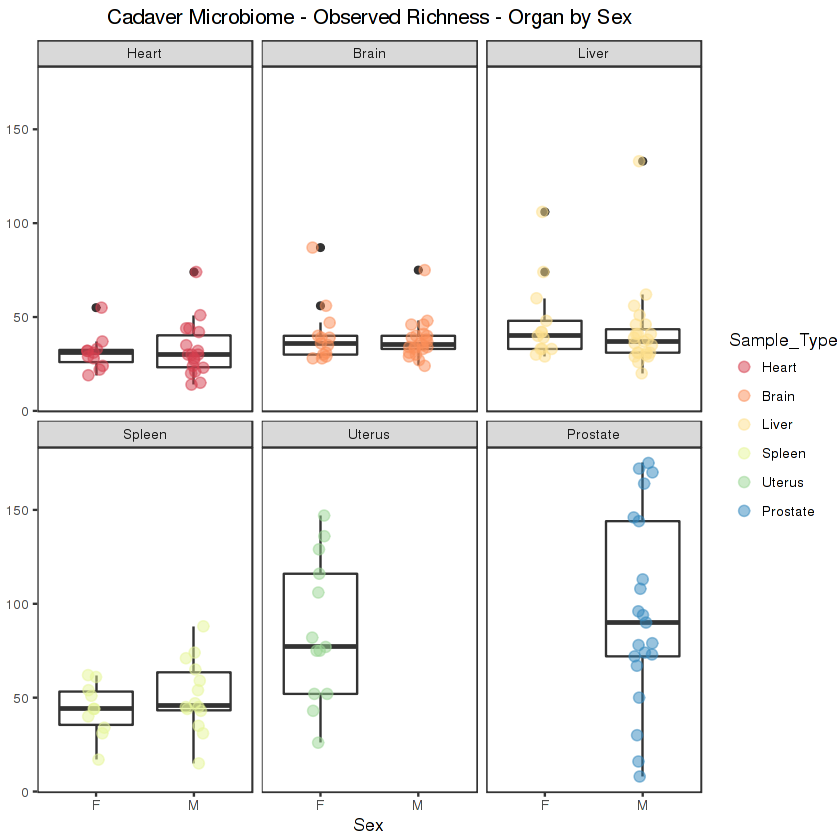

In [98]:
p = ggplot(na.omit(dfobs), aes(x = Sex, y = Observed)) + ggtitle("Cadaver Microbiome - Observed Richness - Organ by Sex") 

p = p + geom_boxplot() + ylab("Observed")

p = p + geom_point(size = 2.5,alpha=.5, aes(color = Sample_Type),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Sample_Type)

p

In [104]:
heart <- dfobs[which(dfobs$Sample_Type=='Heart'),]
brain <- dfobs[which(dfobs$Sample_Type=='Brain'),]
liver <- dfobs[which(dfobs$Sample_Type=='Liver'),]
spleen <- dfobs[which(dfobs$Sample_Type=='Spleen'),]
uterus <- dfobs[which(dfobs$Sample_Type=='Uterus'),]
prostate <- dfobs[which(dfobs$Sample_Type=='Prostate'),]
gonad <- rbind(uterus,prostate)

In [105]:
krusk_heart = kruskal.test(Observed ~ Sex, data=heart) 
krusk_brain = kruskal.test(Observed ~ Sex, data=brain) 
krusk_liver = kruskal.test(Observed ~ Sex, data=liver) 
krusk_spleen = kruskal.test(Observed ~ Sex, data=spleen) 
krusk_gonad = kruskal.test(Observed ~ Sex, data=gonad)  

krusk_heart
krusk_brain
krusk_liver
krusk_spleen
krusk_gonad


	Kruskal-Wallis rank sum test

data:  Observed by Sex
Kruskal-Wallis chi-squared = 0.032411, df = 1, p-value = 0.8571



	Kruskal-Wallis rank sum test

data:  Observed by Sex
Kruskal-Wallis chi-squared = 0.0026297, df = 1, p-value = 0.9591



	Kruskal-Wallis rank sum test

data:  Observed by Sex
Kruskal-Wallis chi-squared = 1.0124, df = 1, p-value = 0.3143



	Kruskal-Wallis rank sum test

data:  Observed by Sex
Kruskal-Wallis chi-squared = 0.99388, df = 1, p-value = 0.3188



	Kruskal-Wallis rank sum test

data:  Observed by Sex
Kruskal-Wallis chi-squared = 0.26413, df = 1, p-value = 0.6073


# Beta diversity

### Calculate diversity metrics

In [8]:
# Weighted Unifrac (wunif)
cadaver.dist.wunif = distance(cadaver, method = "wunifrac", type = "samples")

# Unweighted Unifrac (unif)
cadaver.dist.unif = distance(cadaver, method = "unifrac", type = "samples")

# Bray-Curtis (bc)
cadaver.dist.bc = distance(cadaver, method = "bray", type = "samples")


Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGATGTGAAAACCCAGGGCTTAACCCTGGGACTGCATTGGAAACTGTCTGGCTCGAGTGCCGGAGAGGTAAGCGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGTGGTATGGCAAGTCAGAAGTGAAAACCCAGGGCTTAACTCTGGGACTGCTTTTGAAACTGTCAGACTGGAGTGCAGGAGAGGTAAGCGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”

### PERMANOVA (ADONIS) tests

In [6]:
cadaver.df = data.frame(sample_data(cadaver))

In [9]:
# Wunif
cadaver.wunif.adtest = adonis2(cadaver.dist.wunif ~ Sex + Age + BMI_Cat + Manner_of_death + Sample_Type + PMI_hrs, by = "margin", data=cadaver.df)
cadaver.wunif.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,2,0.4780022,0.031315359,3.344303,0.001
Age,1,0.1349102,0.008838369,1.887775,0.080
BMI_Cat,3,0.8163294,0.053480191,3.807587,0.001
Manner_of_death,6,1.1141580,0.072991837,2.598371,0.001
Sample_Type,5,1.6322629,0.106934445,4.567997,0.001
PMI_hrs,1,0.5343265,0.035005334,7.476742,0.001
Residual,139,9.9336559,0.650783616,NA,NA
Total,157,15.2641457,1.000000000,NA,NA


In [10]:
# Wunif Bonferroni Correction
pval = c("0.001", "0.080", "0.001", "0.001", "0.001", "0.001")
padj.cadaver.wunif.ad.test = p.adjust(pval, method = "bonferroni")
padj.cadaver.wunif.ad.test

[1] 0.006 0.480 0.006 0.006 0.006 0.006

In [11]:
# Unif
cadaver.unif.adtest = adonis2(cadaver.dist.unif ~ Sex + Age + BMI_Cat + Manner_of_death + Sample_Type + PMI_hrs, by = "margin", data=cadaver.df)
cadaver.unif.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,2,0.4924850,0.01681999,1.708494,0.047
Age,1,0.3243406,0.01107730,2.250358,0.031
BMI_Cat,3,0.9262402,0.03163416,2.142165,0.004
Manner_of_death,6,1.4289054,0.04880184,1.652352,0.005
Sample_Type,5,5.2511061,0.17934261,7.286706,0.001
PMI_hrs,1,0.4239416,0.01447900,2.941416,0.008
Residual,139,20.0338464,0.68422199,NA,NA
Total,157,29.2797463,1.00000000,NA,NA


In [12]:
# Unif Bonferroni Correction
pval = c("0.047", "0.031", "0.004", "0.005", "0.001", "0.008")
padj.cadaver.unif.ad.test = p.adjust(pval, method = "bonferroni")
padj.cadaver.unif.ad.test

[1] 0.282 0.186 0.024 0.030 0.006 0.048

In [13]:
# BC
cadaver.bc.adtest = adonis2(cadaver.dist.bc ~ Sex + Age + BMI_Cat + Manner_of_death + Sample_Type + PMI_hrs, by = "margin", data=cadaver.df)
cadaver.bc.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,2,1.6000825,0.03203365,3.255335,0.001
Age,1,0.7394453,0.01480369,3.008773,0.003
BMI_Cat,3,2.2987834,0.04602164,3.117885,0.001
Manner_of_death,6,4.0190153,0.08046068,2.725535,0.001
Sample_Type,5,4.9378539,0.09885583,4.018385,0.001
PMI_hrs,1,1.2425950,0.02487675,5.056068,0.001
Residual,139,34.1610694,0.68390456,NA,NA
Total,157,49.9500533,1.00000000,NA,NA


In [14]:
# BC Bonferroni Correction
pval = c("0.001", "0.003", "0.001", "0.001", "0.001", "0.001")
padj.cadaver.bc.ad.test = p.adjust(pval, method = "bonferroni")
padj.cadaver.bc.ad.test

[1] 0.006 0.018 0.006 0.006 0.006 0.006

### PCoA Plots

In [6]:
cadaver.wunif.log = ordinate(cadaver, method = "PCoA", distance = "wunifrac")
cadaver.wunif.evals = cadaver.wunif.log$values$Eigenvalues

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGTGTAGGCGGTTTGTTAAGCGTGTTGTGAAATTTAGATGCTCAACATTTAACTTGCAGCGCGAACTGTCAGACTTGAGTACACGCAACGTATGCGGAATTCATGG -- in the phylogenetic tree in the data you provided.”

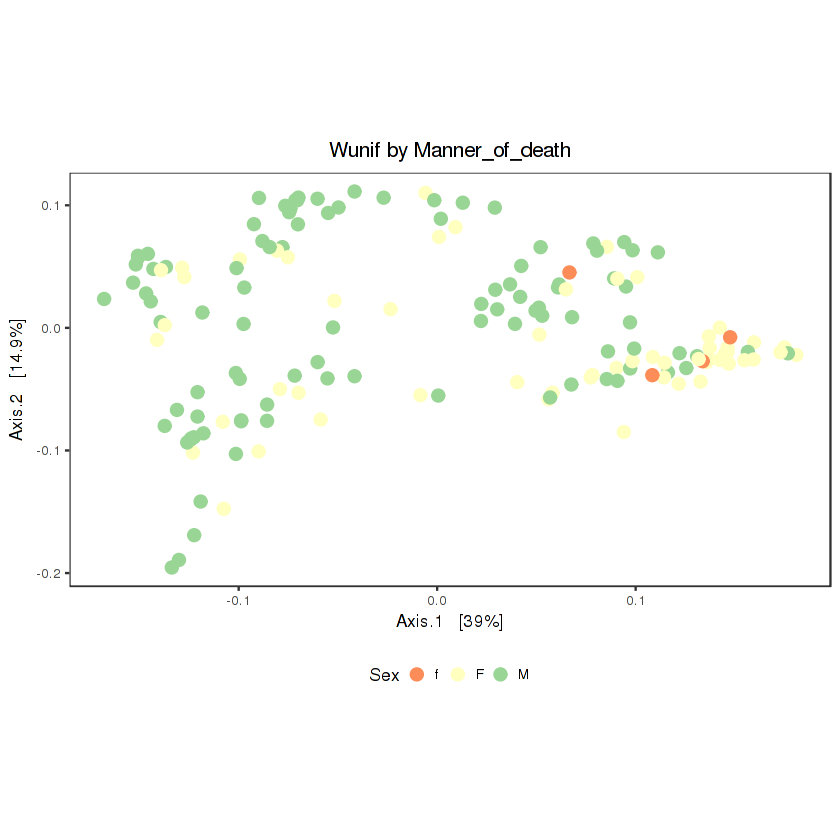

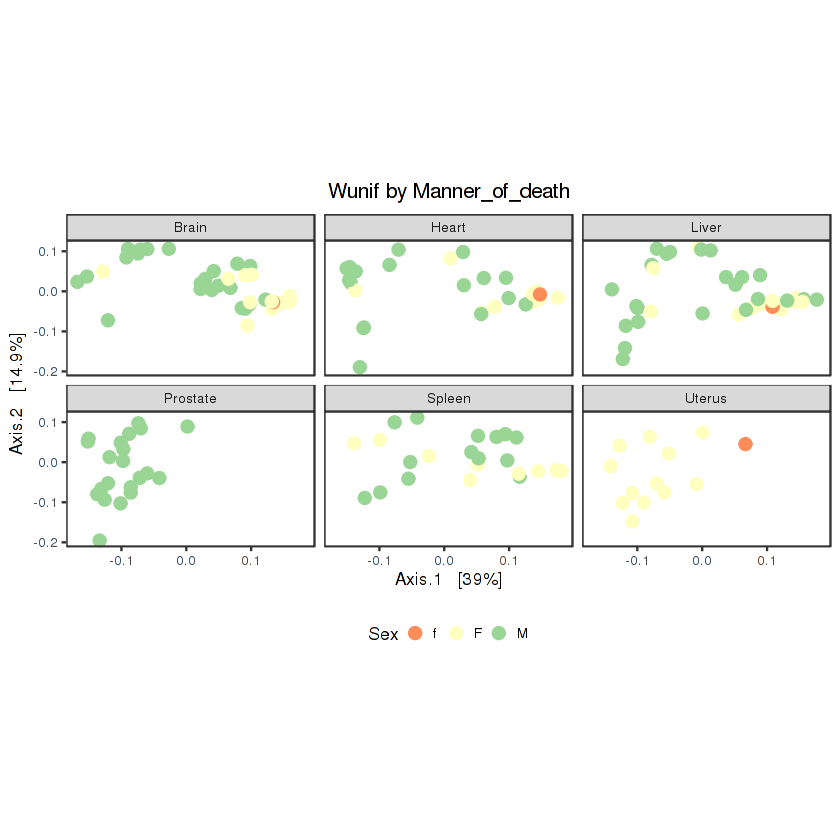

In [18]:
#Wunif by Sex

#

p = plot_ordination(cadaver, cadaver.wunif.log, color = "Sex") + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +   
    ggtitle("Wunif by Manner_of_death") + 
    geom_point(size=3) +
    scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           legend.position = "bottom",
                           plot.title = element_text(hjust = 0.5),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p2 = p + facet_wrap(~Sample_Type)

p

p2

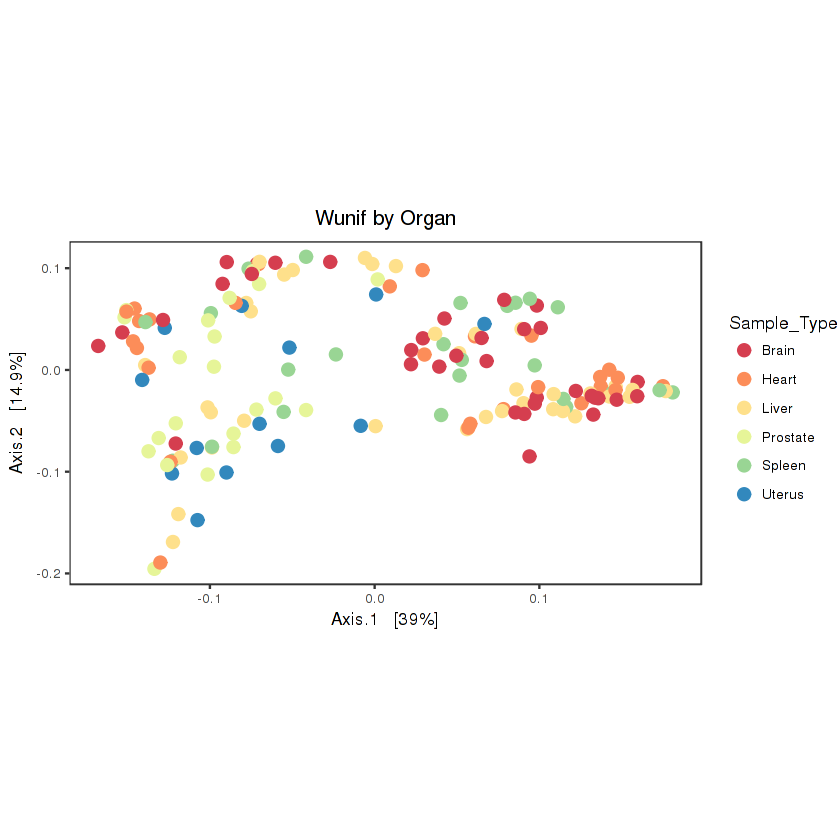

In [25]:
#Wunif by Organ

p = plot_ordination(cadaver, cadaver.wunif.log, color = "Sample_Type") + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +   
    ggtitle("Wunif by Organ") + 
    geom_point(size=3) +
    scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           #legend.position = "bottom",
                           plot.title = element_text(hjust = 0.5),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

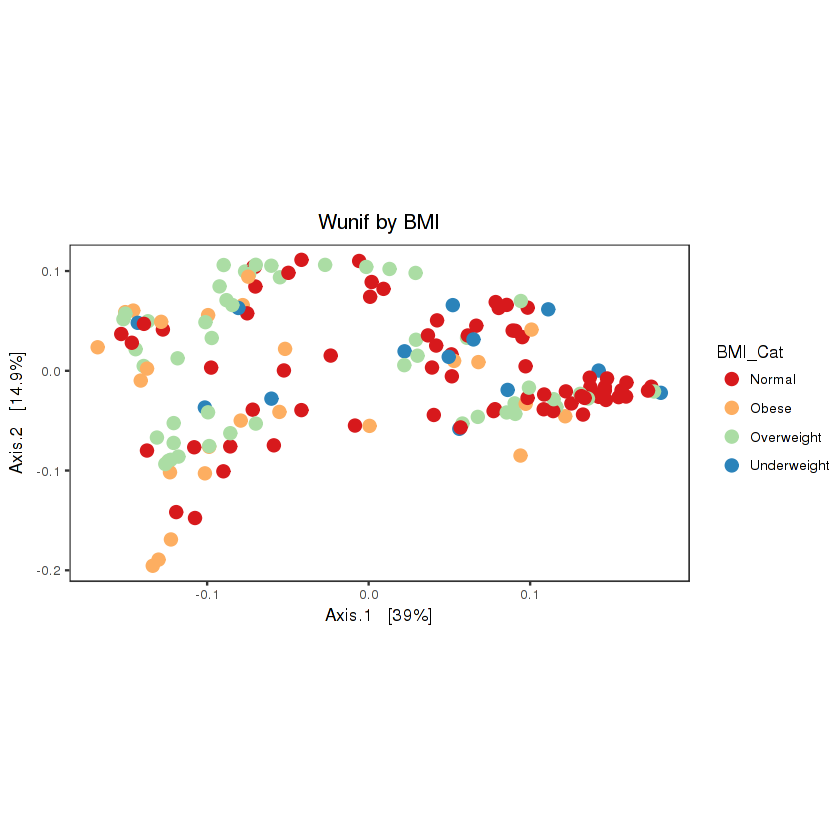

In [24]:
#Wunif by BMI

p = plot_ordination(cadaver, cadaver.wunif.log, color = "BMI_Cat") + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +   
    ggtitle("Wunif by BMI") + 
    geom_point(size=3) +
    scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           #legend.position = "bottom",
                           plot.title = element_text(hjust = 0.5),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

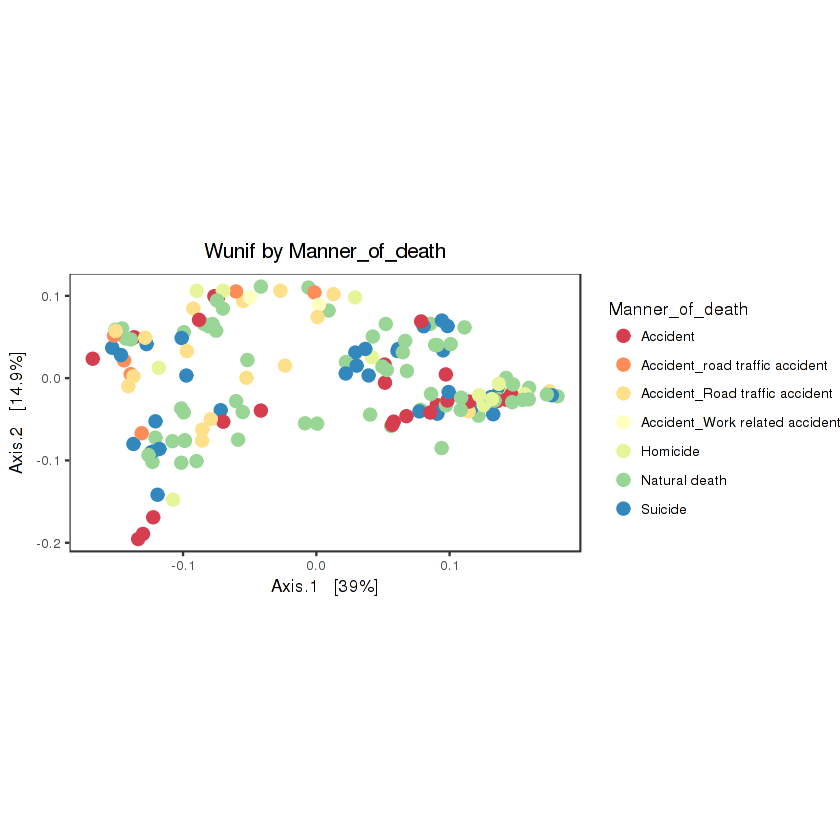

In [14]:
#Wunif by Manner of death

p = plot_ordination(cadaver, cadaver.wunif.log, color = "Manner_of_death") + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +   
    ggtitle("Wunif by Manner_of_death") + 
    geom_point(size=3) +
    scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           #legend.position = "bottom",
                           plot.title = element_text(hjust = 0.5),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

## Relative Abundance

In [101]:
cadaver.mdf = psmelt(cadaver)

In [91]:
# Manner of death by Organ

N = 8

topN = cadaver.mdf %>%
    group_by(Rank3) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank3) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank3")

mdfall.other = cadaver.mdf %>%
    mutate(Rank3.other = ifelse(Rank3 %in% topN, as.character(Rank3), "Other")) %>%
    group_by(Manner_of_death, Sample_Type, Sample, Rank3.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Manner_of_death, Sample_Type, Sample, Rank3.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank3.other))
#mdfall.summary

Selecting by m


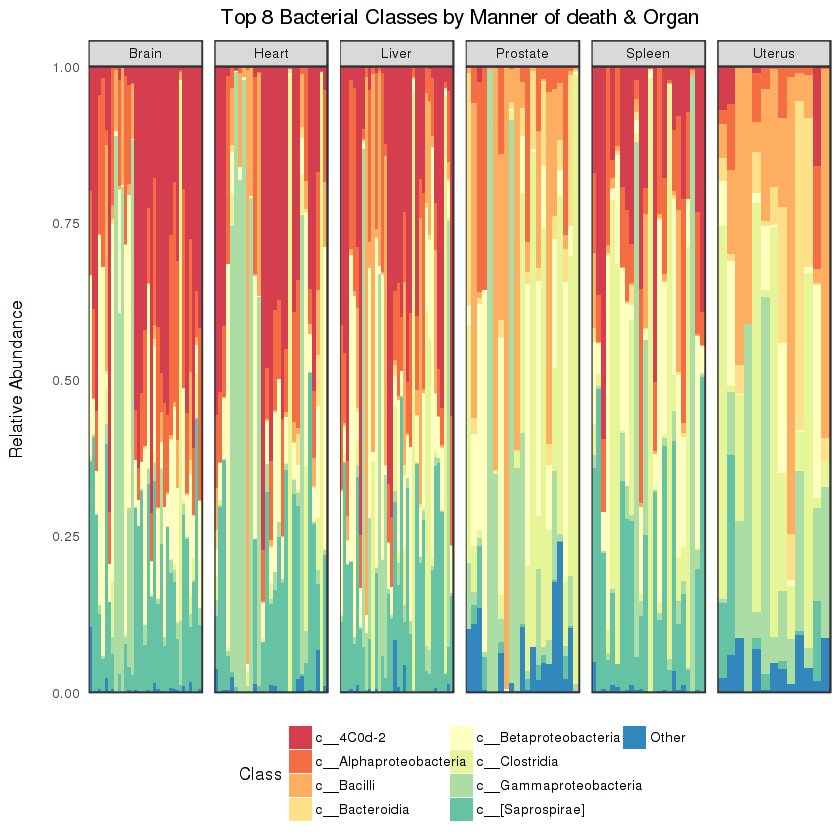

In [94]:
p = ggplot(mdfall.other[order(mdfall.other$Rank3.other,decreasing=T),], aes(x=Sample, y = Abundance, fill = Rank3.other))
                        
#p = p + facet_grid(Sample_Type~Manner_of_death) + 

p = p + facet_wrap(~Sample_Type, shrink = TRUE, scales = "free_x", ncol = 6) + 
            ylab("Relative Abundance") + 
            geom_bar(stat="identity") +  
            scale_y_continuous(expand = c(0,0)) + 
            scale_fill_brewer(palette = "Spectral", na.value= "#0E024C") + 
            guides(fill = guide_legend(title = "Class", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(
            panel.grid.major = element_blank(),
            axis.title.y=element_text(margin=margin(0,20,0,0)),
            text=element_text(size=10, color="black",family="Arial"),
            panel.grid.minor = element_blank(),
            axis.text.x = element_blank(),
            axis.ticks = element_blank(),
            #axis.text.x=element_text(angle=90,vjust=0.4),
            legend.key.size = unit(1, "mm"),
            legend.spacing.x = unit(1,"in"),
            legend.position = "bottom",
            axis.title.x=element_blank(),
            panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Top 8 Bacterial Classes by Manner of death & Organ") + theme(plot.title = element_text(hjust = 0.5))

p

In [102]:
# Organ by Sex

N = 8

topN = cadaver.mdf %>%
    group_by(Rank3) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank3) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank3")

mdfall.other = cadaver.mdf %>%
    mutate(Rank3.other = ifelse(Rank3 %in% topN, as.character(Rank3), "Other")) %>%
    group_by(Sex, Sample_Type, Sample, Rank3.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Sex, Sample_Type, Sample, Rank3.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank3.other))

Selecting by m


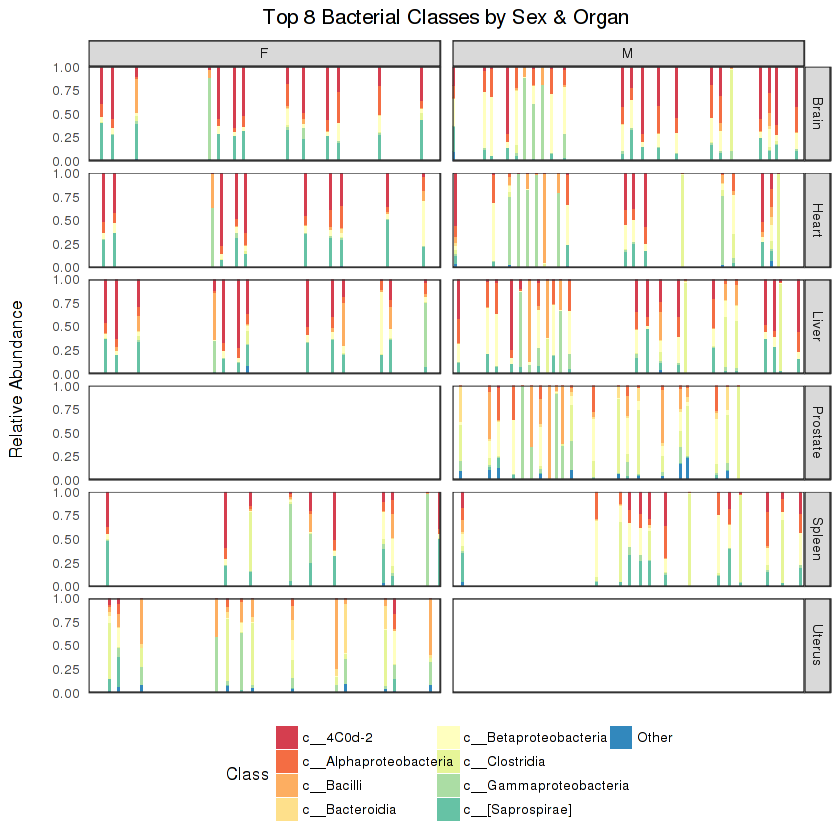

In [103]:
p = ggplot(mdfall.other[order(mdfall.other$Rank3.other,decreasing=T),], aes(x=Sample, y = Abundance, fill = Rank3.other))
                        
p = p + facet_grid(Sample_Type~Sex) + 

#p = p + facet_wrap(~Sample_Type, shrink = TRUE, scales = "free_x", ncol = 6) + 
            ylab("Relative Abundance") + 
            geom_bar(stat="identity") +  
            scale_y_continuous(expand = c(0,0)) + 
            scale_fill_brewer(palette = "Spectral", na.value= "#0E024C") + 
            guides(fill = guide_legend(title = "Class", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(
            panel.grid.major = element_blank(),
            axis.title.y=element_text(margin=margin(0,20,0,0)),
            text=element_text(size=10, color="black",family="Arial"),
            panel.grid.minor = element_blank(),
            axis.text.x = element_blank(),
            axis.ticks = element_blank(),
            #axis.text.x=element_text(angle=90,vjust=0.4),
            legend.key.size = unit(1, "mm"),
            legend.spacing.x = unit(1,"in"),
            legend.position = "bottom",
            axis.title.x=element_blank(),
            panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Top 8 Bacterial Classes by Sex & Organ") + theme(plot.title = element_text(hjust = 0.5))

p